# 1. Perkenalan

- Nama : Ahmad Junjung Sudrajad
- Batch : RMT - 033
- Objectives : Project ini memiliki tujuan utama yakni sentiment analysis kesehatan mental berdasarkan dataset yang disediakan dengan implementasi penggunaan NLP sebagai metodenya serta penerepan Deep Learning sebagai algoritma model serta pendekatan pre-processing pada dataset yang akan digunakan. Sehingga dalam outputnya dapat memprediksi suatu kasus kesehatan mental berdasarkan kalimat yang ada di dalam real case.
- Deployment : [link](https://huggingface.co/spaces/junjung214/Sentiment_Analysis)

# 2. Import Library

In [1]:
# Downgrade version of TensorFlow and tf-keras

!pip install --upgrade "tensorflow<2.16" "tf-keras<2.16"

In [70]:
# Import Libraries
import time
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as tf_hub

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# plot chart
import plotly.graph_objects as go
import plotly.figure_factory as ff # for distribution plot
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from wordcloud import WordCloud, STOPWORDS
from collections import Counter

# Download necessary NLTK data files
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Dropout, Reshape, BatchNormalization

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score
from keras.models import load_model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 3. Load Data

Dalam Project Kali ini akan menggunakan dataset dari kaggle
- Topic : Sentiment Analysis for Mental Health
- The dataset consists of statements tagged with one of the following seven mental health statuses:
    1. Normal
    2. Depression
    3. Suicidal
    4. Anxiety
    5. Stress
    6. Bi-Polar
    7. Personality Disorder
- Sumber data : [Kaggle](https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/data)

In [5]:
df_ori = pd.read_csv('/content/drive/MyDrive/p2-ftds033-rmt-g7-junjung214/Combined Data.csv')
df_ori

Unnamed: 0                                          statement   status
0               0                                         oh my gosh  Anxiety
1               1  trouble sleeping, confused mind, restless hear...  Anxiety
2               2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3               3  I've shifted my focus to something else but I'...  Anxiety
4               4  I'm restless and restless, it's been a month n...  Anxiety
...           ...                                                ...      ...
53038       53038  Nobody takes me seriously I’ve (24M) dealt wit...  Anxiety
53039       53039  selfishness  "I don't feel very good, it's lik...  Anxiety
53040       53040  Is there any way to sleep better? I can't slee...  Anxiety
53041       53041  Public speaking tips? Hi, all. I have to give ...  Anxiety
53042       53042  I have really bad door anxiety! It's not about...  Anxiety

[53043 rows x 3 columns]

In [6]:
df_ori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


Dalam dataset ini memilki 53k entiti atau baris dengan 3 feature yang dimana berisikan Unamed:0 yakni ID pada setiap baris statement berupa object dan Status object

In [7]:
df_ori.isnull().sum()

Unnamed: 0      0
statement     362
status          0
dtype: int64

In [8]:
#pengecekkan duplikassi data pada feature statment saja karena apabila mengecek keseluruhan tidak akan duplikasi karena ada uniqueID setiap baris
dup_data = df_ori.loc[df_ori.statement.duplicated(keep=False)]
dup_data.shape[0]

3373

Dalam hasil diatas didapati bahwasanya dalam dataset ini memilki null values dan duplikasi data kolom statement

In [9]:
df_ori.status.value_counts()

status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

Dalam kolom target atau status memilki 7 target

## 3.1 Kesimpulan Data


- Dalam dataset ini memiliki beberapa Null Values yang perlu dihandling
- Serta dalam dataset ini juga memiliki duplikasi dataset yang perlu dicek apakah duplikasi nya juga sama dengan target nya sehingga bisa dihandling dengan cara yang lebih objective
- Dalam Target persebaran data tidak merata

# 4. EDA

In [10]:
df_eda = df_ori.copy()

## 4.1 Distribution Of Target

In [11]:
df_eda.status.value_counts()

status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

In [12]:
# Data dalam bentuk Series
status_count = pd.Series({
    "Normal": 16351,
    "Depression": 15404,
    "Suicidal": 10653,
    "Anxiety": 3888,
    "Bipolar": 2877,
    "Stress": 2669,
    "Personality disorder": 1201
})

# Menghitung total jumlah
total_count = status_count.sum()

# Menghitung persentase
status_percentage = (status_count / total_count) * 100

# Membuat DataFrame baru untuk plotting
df = pd.DataFrame({
    'status': status_count.index,
    'count': status_count.values,
    'percentage': status_percentage.values
})

# Membuat bar chart dengan Plotly
fig = px.bar(
    df,
    x='status',
    y='count',
    text=df['percentage'].apply(lambda x: f'{x:.2f}%'), # Menampilkan persentase pada bar
    title='Distribusi Status Kesehatan Mental',
    labels={'status': 'Status', 'count': 'Count'}
)

# Menyesuaikan layout plot
fig.update_layout(
    xaxis_title='Status',
    yaxis_title='Count',
    yaxis=dict(tickformat=',d'), # Menampilkan y-axis dalam format angka
    template='plotly_white'
)

# Menampilkan plot
fig.show()

Dalam persebaran data diatas dapat dilihat bahwasanya sngat tidak balance dan ini juga akan mempengaruhi performa model kedepannya

## 4.2 Missing Data

In [13]:

#Cek missing Data
nan_df = df_eda.loc[df_eda.statement.isna()]
nan_count = nan_df.shape[0]
not_nan_count = df_eda.loc[~df_eda.statement.isna()].shape[0]
fig = go.Figure(data=[go.Pie(labels=['NaN', 'Good'], values=[nan_count, not_nan_count],  pull = [0.2, 0])])
fig.update_layout(title='Missing Data')
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20)
fig.show()

Dalam dataset terdapat 362 missin value dimana ini bisa langsung di drop karena persentase hanya 0.682%

## 4.3 Duplicate Data

Dalam bagian ini akan mengecek duplikasi data apakah hanya ada di fetrue statement saja atau bukan

In [14]:
# pengcekan duplkasi data
dup_df = df_eda.loc[df_eda.statement.duplicated(keep=False)]
dup_df.shape[0]

3373

Kita lihat untuk 10 data yang terduplikasi

In [15]:
#mnampilkan data duplikasi
dup_df.sort_values('statement').head(10)

Unnamed: 0                                          statement   status
52041       52041  "Buy Friends" comment? My mother doesn't have ...  Anxiety
53027       53027  "Buy Friends" comment? My mother doesn't have ...  Anxiety
49300       49300  "Desk Toys for Your Stressful Day!"  \n\nDesk ...   Stress
48420       48420  "Desk Toys for Your Stressful Day!"  \n\nDesk ...   Stress
18             18  "No regrets or grudges/angry at things that ha...  Anxiety
309           309  "No regrets or grudges/angry at things that ha...  Anxiety
504           504  "No regrets or grudges/angry at things that ha...  Anxiety
452           452  "No regrets or grudges/angry at things that ha...  Anxiety
97             97  "No regrets or grudges/angry at things that ha...  Anxiety
49348       49348  "Reduce Worry and Chill Out – The Best Gummies...   Stress

Pengecekkan data duplikat apakah memiliki duplikasi yang sama dengan kolom status

In [16]:
#membuat suatu var untuk menampung data hasil duplikasi
group_dup_df = dup_df.groupby(['statement'])['status'].apply(set).reset_index()
print(f'jumlah duplikasi data yang sama antara statement dengan status : {len(group_dup_df)}')

jumlah duplikasi data yang sama antara statement dengan status : 1403


In [17]:
percentage = 1403/len(df_eda)*100
print(f'Persentase Duplikasi data : {percentage}%')

Persentase Duplikasi data : 2.6450238485756836%


Dari hasil diatas dapat dilihat bahwasanya terdapat duplikasi data sebanyak 1403 yang memiliki persentase 2.6% yang cenderung juga kecil jadi bisa langsung di drop saja

## 4.4 Penghitungan Statement

Dalam bagian ini akan mengcek sebarapa banyak kata yang muncul dalam satu statement

In [18]:
#menghitung jumlah setiap huruf yang muncul dalam satu barisstatement
df_eda['statement_len'] = df_eda['statement'].apply(lambda s : len(s) if s == s else 0)

In [19]:
#central tendency terhadap panjangnya suatu kalimat
df_eda['statement_len'].describe().reset_index().style.format(precision=2)

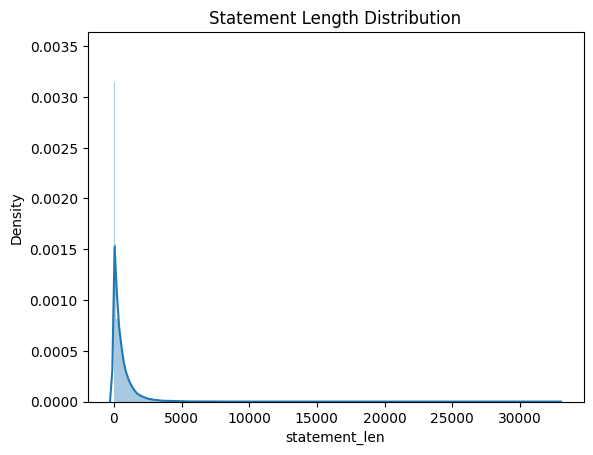

In [20]:
#membuat plot histogram

sns.histplot(
    df_eda['statement_len'], kde=True,
    stat="density", kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4),
)
plt.title('Statement Length Distribution')
plt.show()

Dari hasil diatas dapat dilihat ada kecenderunngan data yang memiliki nilai kecil terhadap suatu huruf maka perlu dilihat seperti apa terleibh dahulu

In [21]:
#menampilkan data untuk terkecil
df_eda.sort_values(by=['statement_len']).head(10)

Unnamed: 0 statement                status  statement_len
51539       51539       NaN  Personality disorder              0
52631       52631       NaN               Anxiety              0
50921       50921       NaN  Personality disorder              0
52637       52637       NaN               Anxiety              0
52651       52651       NaN               Anxiety              0
50899       50899       NaN  Personality disorder              0
52695       52695       NaN               Anxiety              0
52747       52747       NaN               Anxiety              0
52757       52757       NaN               Anxiety              0
52759       52759       NaN               Anxiety              0

Karena data belum dihandling Null Values maka akan di drop terlebih dahulu

In [22]:
#drop data null values
df_eda.dropna(subset=["statement"],inplace=True)
#tampilkan data dari terkecil
df_eda.sort_values(by=['statement_len']).head(10)

Unnamed: 0 statement      status  statement_len
5889         5889        lw      Normal              2
1542         1542       bye      Normal              3
31131       31131       so?      Normal              3
4001         4001       sad      Normal              3
39874       39874       plz  Depression              3
31478       31478       no.      Normal              3
33879       33879       so?      Normal              3
33795       33795       so?      Normal              3
33473       33473       so?      Normal              3
5356         5356       dog      Normal              3

Dapat dilihat dalam kasus seperti ini maka perlu ada nya filter terahdap data yang akan di train nanti kedepannya sehingga data data yang terlalu sedikit tidak akan masuk dalam proses train

In [23]:
#tampilkan data dari terbesar
df_eda.sort_values(by=['statement_len'], ascending=False).head(10)

Unnamed: 0                                          statement  \
13293       13293  I cannot TAKE IT ANYMORE. I cannot TAKE IT ANY...   
51396       51396  Please help me understand what I went through ...   
10834       10834  I have only 1 person I can somewhat open to bu...   
46660       46660  DEPRESSION HAS A PURPOSE: HOW TO USE IT RIGHT ...   
9416         9416  AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...   
39752       39752  it doesn t matter anymore i m going to copy an...   
11581       11581  I no longer know what else to do but write thi...   
21858       21858  I constantly repeat to myself that I have neve...   
11636       11636  And has life gotten better?&amp;#x200B;No. Eve...   
11537       11537  The title is not meant to discourage others, b...   

                     status  statement_len  
13293              Suicidal          32759  
51396  Personality disorder          27588  
10834              Suicidal          27390  
46660               Bipolar          26163  
9416               Suicidal          25302  
39752            Depression          19822  
11581            Depression          13530  
21858            Depression          13054  
11636            Depression          12819  
11537            Depression          12304

## 4.5 Status Frequency

Akan mengecek by world cloud kata apa saja yang sering muncul

(-0.5, 1599.5, 599.5, -0.5)

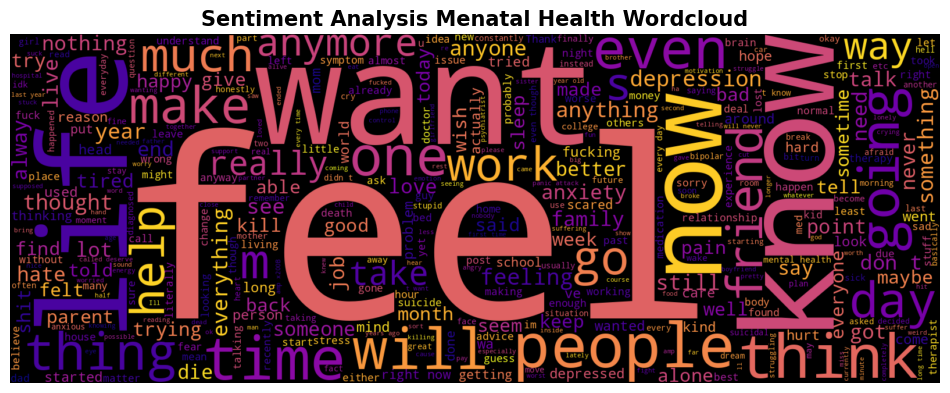

In [24]:
# wordcloud dari keseluruhan dataset
plt.figure(figsize=(12,12))
wc = WordCloud(max_words=1000,
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=False,
               stopwords=STOPWORDS).generate(' '.join(df_eda.statement))

plt.title("Sentiment Analysis Menatal Health Wordcloud", size=15, weight='bold')
plt.imshow(wc, interpolation= "bilinear")
plt.axis('off')

### 4.5.1 Status Normal

Kali ini akan mengecek untuk status normal saja

In [25]:
normal_df = df_eda[df_eda['status'] == 'Normal']
normal_df.head()

Unnamed: 0                                          statement  status  \
733         733      Gr gr dreaming of ex crush to be my game, God  Normal   
734         734                                 wkwkwk what a joke  Normal   
735         735  Leaves are also standby in front of the PC ......  Normal   
736         736     Thank God even though it's just a ride through  Normal   
737         737  wedding teaser concept using the song day6 - o...  Normal   

     statement_len  
733             45  
734             18  
735             87  
736             46  
737             71

(-0.5, 1599.5, 599.5, -0.5)

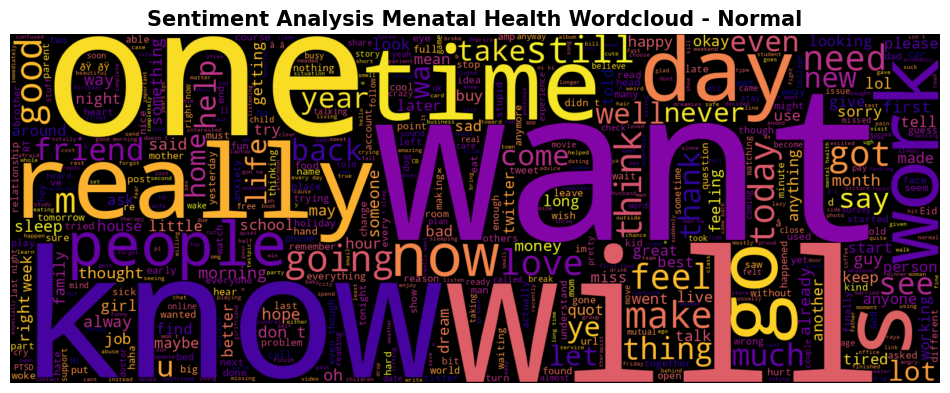

In [26]:
# wordcloud dari status Normal
plt.figure(figsize=(12,12))
wc = WordCloud(max_words=1000,
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=False,
               stopwords=STOPWORDS).generate(' '.join(normal_df.statement))

plt.title("Sentiment Analysis Menatal Health Wordcloud - Normal", size=15, weight='bold')
plt.imshow(wc, interpolation= "bilinear")
plt.axis('off')

Dari hasil diatas dapat dilihat akan ada kecenderungan prediksi model akan normal apabila didominasi oleh kata kata yang muncul dalam wordcloud diatas

### 4.5.2 Status Depression

Dalam bagian ini akan memvisualkan kata apa saja yang sering muncul didalam Depresion

In [27]:
#Membbuat dataframe yang baru yang berisikan Depression saja
depres_df = df_eda[df_eda.status == 'Depression']
depres_df

Unnamed: 0                                          statement  \
6982         6982  I recently went through a breakup and she said...   
6983         6983  I do not know how to navigate these feelings, ...   
6984         6984  So I have been with my bf for 5 months , and h...   
6986         6986  I have been severly bullied since i was 5 till...   
6988         6988  My mom made me go to a camp that she knows I h...   
...           ...                                                ...   
48283       48283  solutions So, when I have my real bad downs th...   
48284       48284  I’m pretty sure I’m depressed.. Ive been feeli...   
48285       48285  I can’t be bothered anymore. I’m a 22 year old...   
48286       48286  Depression feels like you’re drowning and ther...   
48287       48287  mental hospital- payment and ward logistic que...   

           status  statement_len  
6982   Depression            543  
6983   Depression           1510  
6984   Depression            625  
6986   Depression           1006  
6988   Depression            302  
...           ...            ...  
48283  Depression            549  
48284  Depression            117  
48285  Depression           2427  
48286  Depression             98  
48287  Depression            461  

[15404 rows x 4 columns]

(-0.5, 1599.5, 599.5, -0.5)

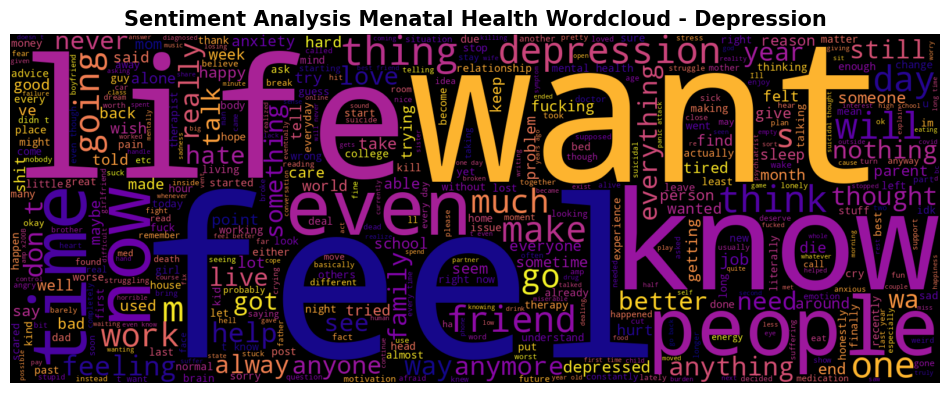

In [28]:
# wordcloud dari status Normal
plt.figure(figsize=(12,12))
wc = WordCloud(max_words=1000,
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=False,
               stopwords=STOPWORDS).generate(' '.join(depres_df .statement))

plt.title("Sentiment Analysis Menatal Health Wordcloud - Depression", size=15, weight='bold')
plt.imshow(wc, interpolation= "bilinear")
plt.axis('off')

Dari hasil diatas dapat dilihat akan ada kecenderungan prediksi model akan Depresion apabila didominasi oleh kata kata yang muncul dalam wordcloud diatas

### 4.5.3 Status Suicidal

Dalam bagiani ini akan mengecek kata yang sering muncul dengna menggunakan wordcloud pada status Suicidal

In [29]:
suicid_df = df_eda[df_eda.status == 'Suicidal']
suicid_df.head(3)

Unnamed: 0                                          statement    status  \
6985        6985  I am so exhausted of this. Just when I think I...  Suicidal   
6987        6987  I am 20 year old with some good friends but I ...  Suicidal   
6990        6990  it is looming around the corner again. It alwa...  Suicidal   

      statement_len  
6985           1704  
6987            669  
6990            496

(-0.5, 1599.5, 599.5, -0.5)

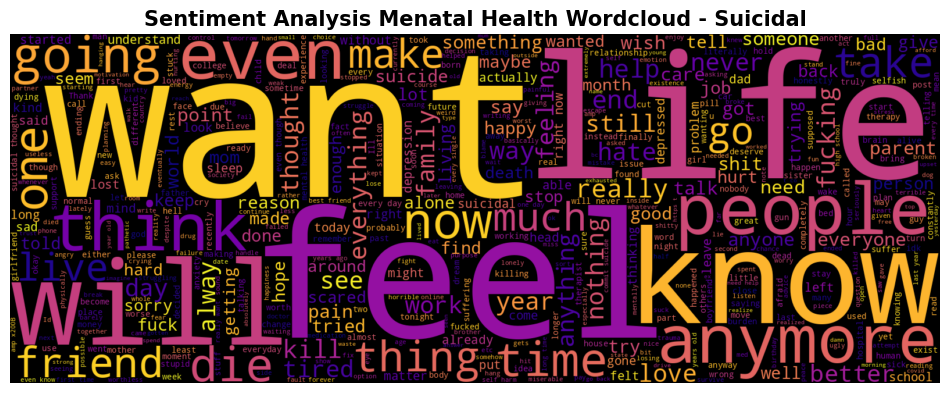

In [30]:
# wordcloud dari status Normal
plt.figure(figsize=(12,12))
wc = WordCloud(max_words=1000,
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=False,
               stopwords=STOPWORDS).generate(' '.join(suicid_df .statement))

plt.title("Sentiment Analysis Menatal Health Wordcloud - Suicidal", size=15, weight='bold')
plt.imshow(wc, interpolation= "bilinear")
plt.axis('off')

Dari hasil diatas dapat dilihat akan ada kecenderungan prediksi model akan Suicidal apabila Depresion oleh kata kata yang muncul dalam wordcloud diatas

### 4.5.4 Stauts Anxiexty

Dalam bagiani ini akan mengecek kata yang sering muncul dengna menggunakan wordcloud pada status Anxiety

In [31]:
#membuat data frame baru untuk staus anxiety saja
anxiety_df = df_eda[df_eda.status == 'Anxiety']
anxiety_df.head(3)

Unnamed: 0                                          statement   status  \
0           0                                         oh my gosh  Anxiety   
1           1  trouble sleeping, confused mind, restless hear...  Anxiety   
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   

   statement_len  
0             10  
1             64  
2             78

(-0.5, 1599.5, 599.5, -0.5)

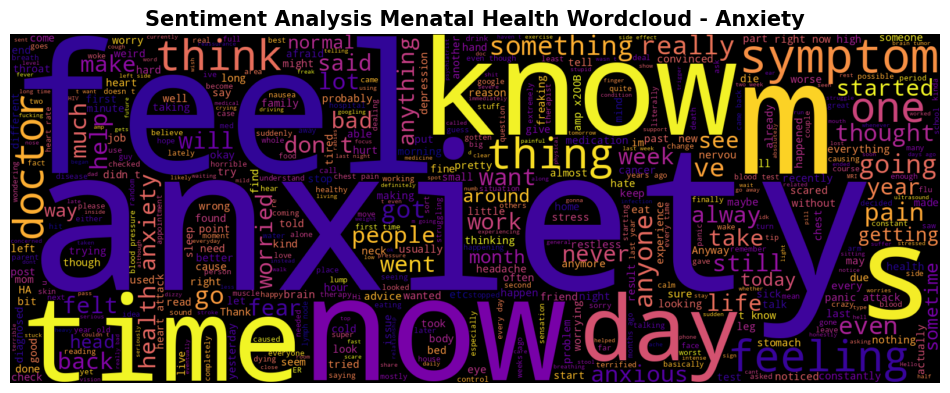

In [32]:
# wordcloud dari status Normal
plt.figure(figsize=(12,12))
wc = WordCloud(max_words=1000,
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=False,
               stopwords=STOPWORDS).generate(' '.join(anxiety_df .statement))

plt.title("Sentiment Analysis Menatal Health Wordcloud - Anxiety", size=15, weight='bold')
plt.imshow(wc, interpolation= "bilinear")
plt.axis('off')

Dari hasil diatas dapat dilihat akan ada kecenderungan prediksi model akan Suicidal apabila Anxiety oleh kata kata yang muncul dalam wordcloud diatas

### 4.5.5 Status Bipolar

Dalam bagian ini akan mengecek status Bipolar dengna menggunakan WordCloud

In [33]:
#membuat dataframe baru yang berisikan bipolar saja
bipolar_df = df_eda[df_eda.status == 'Bipolar']
bipolar_df.head(3)

Unnamed: 0                                          statement   status  \
45394       45394  What birth control are you on? I tried an IUD ...  Bipolar   
45395       45395  Hypersexuality I was diagnosed with bipolar un...  Bipolar   
45396       45396  Meditation I have been using the free meditati...  Bipolar   

       statement_len  
45394            575  
45395            800  
45396            166

(-0.5, 1599.5, 599.5, -0.5)

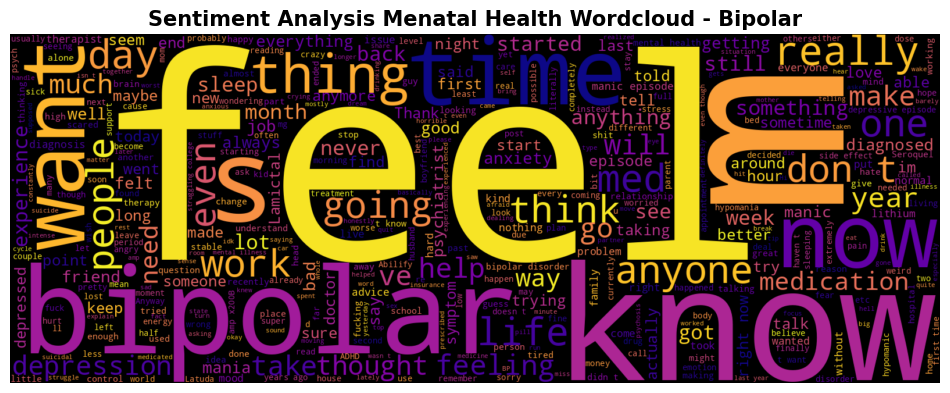

In [34]:
# wordcloud dari status Normal
plt.figure(figsize=(12,12))
wc = WordCloud(max_words=1000,
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=False,
               stopwords=STOPWORDS).generate(' '.join(bipolar_df .statement))

plt.title("Sentiment Analysis Menatal Health Wordcloud - Bipolar", size=15, weight='bold')
plt.imshow(wc, interpolation= "bilinear")
plt.axis('off')

Dari hasil diatas dapat dilihat akan ada kecenderungan prediksi model akan Suicidal apabila Bipolar oleh kata kata yang muncul dalam wordcloud diatas

### 4.5.6 Status Stress

dalam bagian ini akan mengecek kata yang sering muncul didalam status Stress dengan menggunakan WordCloud

In [35]:
#membuat dataframe baru untuk stress saja
stress_df = df_eda[df_eda.status == 'Stress']
stress_df.head(3)

Unnamed: 0                                          statement  status  \
27346       27346  He said he had not felt that way before, sugge...  Stress   
27348       27348  My mom then hit me with the newspaper and it s...  Stress   
27349       27349  until i met my new boyfriend, he is amazing, h...  Stress   

       statement_len  
27346            571  
27348            847  
27349           1277

(-0.5, 1599.5, 599.5, -0.5)

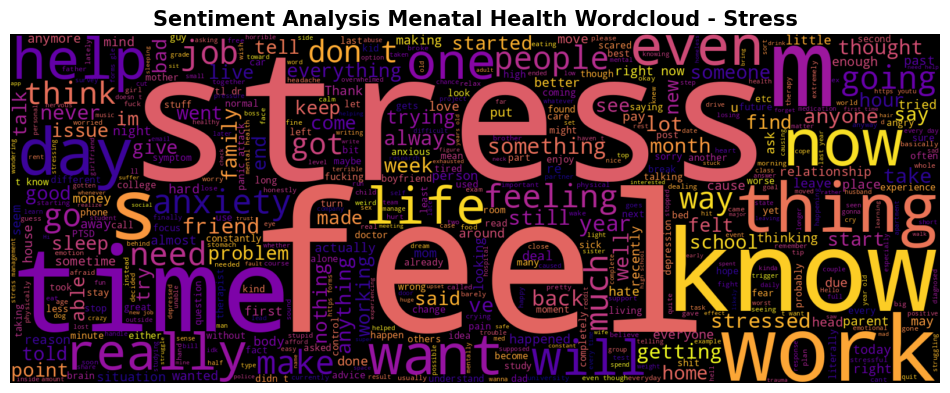

In [36]:
# wordcloud dari status Normal
plt.figure(figsize=(12,12))
wc = WordCloud(max_words=1000,
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=False,
               stopwords=STOPWORDS).generate(' '.join(stress_df .statement))

plt.title("Sentiment Analysis Menatal Health Wordcloud - Stress", size=15, weight='bold')
plt.imshow(wc, interpolation= "bilinear")
plt.axis('off')

Dari hasil diatas dapat dilihat akan ada kecenderungan prediksi model akan Suicidal apabila Stress oleh kata kata yang muncul dalam wordcloud diatas

### 4.5.7 Status Personality Disorder

Dalam bagian ini akan mengecek kata yang sering muncul dalam status personality disorder dengan menggunakan WordCloud

In [37]:
#membuat data frame baru untuk personality disorder
perdis_df = df_eda[df_eda.status == 'Personality disorder']
perdis_df.head(3)

Unnamed: 0                                          statement  \
50654       50654  Is there anyone interested in joining a group ...   
50656       50656  Anyone else have nothing in common with other ...   
50657       50657  Being a ghost would be my ideal form of existe...   

                     status  statement_len  
50654  Personality disorder           1249  
50656  Personality disorder            479  
50657  Personality disorder           1857

(-0.5, 1599.5, 599.5, -0.5)

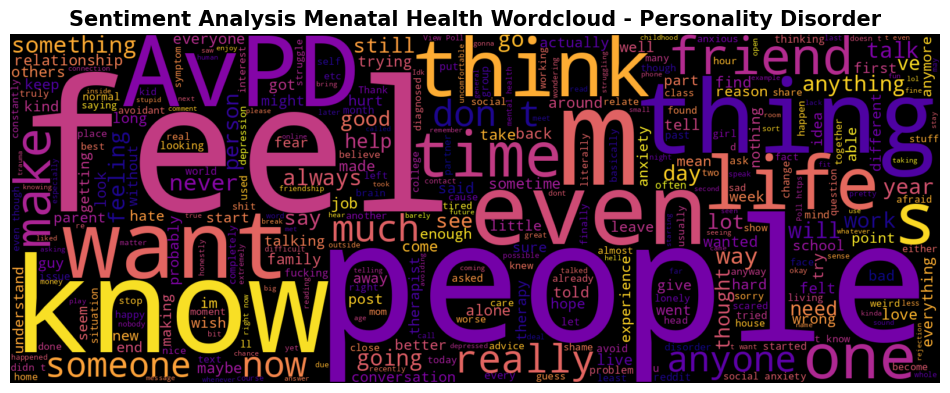

In [38]:
# wordcloud dari status Normal
plt.figure(figsize=(12,12))
wc = WordCloud(max_words=1000,
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=False,
               stopwords=STOPWORDS).generate(' '.join(perdis_df .statement))

plt.title("Sentiment Analysis Menatal Health Wordcloud - Personality Disorder", size=15, weight='bold')
plt.imshow(wc, interpolation= "bilinear")
plt.axis('off')

Dari hasil diatas dapat dilihat akan ada kecenderungan prediksi model akan Personality Disorder apabila Stress oleh kata kata yang muncul dalam wordcloud diatas

### 4.5.8 Conclusion

Setelah melihat hasil dari setiap fitur diatas dapat dikatakan ada beberapa kata yang juga muncul di status lainnya seperti feel, want, know dan lain sbeagainya sehingga perlu dihandling dengan cara menghapuskan kata ini didalam model vocab sehingga tidak merusak hasil dari model

## 4.6 Kesimpulan EDA

Setelah melihat dataset diatas maka dapat disimpulkan sebagai berikut :
- Ada missing value yang dapat dihandling dengan menggunakan Drop 0.6%
- Duplikasi data yang serupa antara statement dan status juga bisa dihandling denggan drop karena hanya 2.3% saja
- Diperlukannya filter terhadap terhadap data minimal dan maksimal inpusehingga performa model lebih bagus dengan implementasi stopwords
- Untuk kata kata yang muncul di beberapa status atau target maka perlu dihapus dalam vocab dengan cara menambahkan dalam data di Stopwords

# 5. Feature Engineering

In [39]:
df_fe = df_ori.copy()

In [40]:
df_fe

Unnamed: 0                                          statement   status
0               0                                         oh my gosh  Anxiety
1               1  trouble sleeping, confused mind, restless hear...  Anxiety
2               2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3               3  I've shifted my focus to something else but I'...  Anxiety
4               4  I'm restless and restless, it's been a month n...  Anxiety
...           ...                                                ...      ...
53038       53038  Nobody takes me seriously I’ve (24M) dealt wit...  Anxiety
53039       53039  selfishness  "I don't feel very good, it's lik...  Anxiety
53040       53040  Is there any way to sleep better? I can't slee...  Anxiety
53041       53041  Public speaking tips? Hi, all. I have to give ...  Anxiety
53042       53042  I have really bad door anxiety! It's not about...  Anxiety

[53043 rows x 3 columns]

Pada bagian ini akan preprocessing data terhadap null values, duplikat values serta pemrosesan data text

## 5.1 Handling Null Values

Dalam Dataset ini karena Null Values hanya 0.6% maka akan didrop secara langsung

In [41]:
#drop data null values
df_fe.dropna(subset=["statement"],inplace=True)

In [42]:
df_fe

Unnamed: 0                                          statement   status
0               0                                         oh my gosh  Anxiety
1               1  trouble sleeping, confused mind, restless hear...  Anxiety
2               2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3               3  I've shifted my focus to something else but I'...  Anxiety
4               4  I'm restless and restless, it's been a month n...  Anxiety
...           ...                                                ...      ...
53038       53038  Nobody takes me seriously I’ve (24M) dealt wit...  Anxiety
53039       53039  selfishness  "I don't feel very good, it's lik...  Anxiety
53040       53040  Is there any way to sleep better? I can't slee...  Anxiety
53041       53041  Public speaking tips? Hi, all. I have to give ...  Anxiety
53042       53042  I have really bad door anxiety! It's not about...  Anxiety

[52681 rows x 3 columns]

## 5.2 Handling Duplicate Values

Dalam kasus ini juga akan di drop berdasrkan kesimpulan EDA

In [43]:
# drop duplicate, keep only first row
df_fe.drop_duplicates(subset=['statement'],keep='first', inplace=True)

## 5.3 Cleaning Dataset

Bagian ini akan memproses dataset dengan membersihakn terhadam atribut yang tidak di inginkan

In [44]:
def preprocess_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove links
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    text = text.strip() #whiste space removal
    return text

df_fe['cleaned_stat'] = df_fe['statement'].apply(lambda x: preprocess_text(x))
df_fe

Unnamed: 0                                          statement   status  \
0               0                                         oh my gosh  Anxiety   
1               1  trouble sleeping, confused mind, restless hear...  Anxiety   
2               2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3               3  I've shifted my focus to something else but I'...  Anxiety   
4               4  I'm restless and restless, it's been a month n...  Anxiety   
...           ...                                                ...      ...   
52835       52835  Anxiety cause faintness when standing up ? As ...  Anxiety   
52836       52836  anxiety heart symptom does anyone else have th...  Anxiety   
52837       52837  Travel Anxiety Hi all! Long time anxiety suffe...  Anxiety   
52839       52839  fomo from things i’m not involved in does anyo...  Anxiety   
52840       52840  Getting through the day How do you get  anythi...  Anxiety   

                                            cleaned_stat  
0                                             oh my gosh  
1      trouble sleeping confused mind restless heart ...  
2      all wrong back off dear forward doubt stay in ...  
3      ive shifted my focus to something else but im ...  
4      im restless and restless its been a month now ...  
...                                                  ...  
52835  anxiety cause faintness when standing up  as t...  
52836  anxiety heart symptom does anyone else have th...  
52837  travel anxiety hi all long time anxiety suffer...  
52839  fomo from things i’m not involved in does anyo...  
52840  getting through the day how do you get  anythi...  

[51073 rows x 4 columns]

## 5.4 Tokenization, Stopwords Removal, & LemmatIzaiton

Dalam bagian ini akan melakukan tokenization dan Stopwords Removal terhadap dataset

In [45]:
# Tokenization and Stopwords Removal
stop_words = set(stopwords.words('english'))
#menambahkan kata kata yang sering muncul didalam lebih dari 1 status :
additional_stopwords = {'feel', 'want', 'know', 'time','day','now','one','people'}
# Menambahkan kata-kata baru ke dalam daftar stopwords
stop_words.update(additional_stopwords)
# Inisialisasi lemmatizer
lemmatizer = WordNetLemmatizer()


In [46]:
#melakukan stopword, tokenizing, lemma ke dalam funciton
def remove_stopwords(text):
    tokens = word_tokenize(text) #tokenize
    tokens = [word for word in tokens if word not in stop_words] #stopword
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize words
    return ' '.join(tokens)

df_fe['cleaned_final'] = df_fe['cleaned_stat'].apply(lambda x: remove_stopwords(x))
df_fe

Unnamed: 0                                          statement   status  \
0               0                                         oh my gosh  Anxiety   
1               1  trouble sleeping, confused mind, restless hear...  Anxiety   
2               2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3               3  I've shifted my focus to something else but I'...  Anxiety   
4               4  I'm restless and restless, it's been a month n...  Anxiety   
...           ...                                                ...      ...   
52835       52835  Anxiety cause faintness when standing up ? As ...  Anxiety   
52836       52836  anxiety heart symptom does anyone else have th...  Anxiety   
52837       52837  Travel Anxiety Hi all! Long time anxiety suffe...  Anxiety   
52839       52839  fomo from things i’m not involved in does anyo...  Anxiety   
52840       52840  Getting through the day How do you get  anythi...  Anxiety   

                                            cleaned_stat  \
0                                             oh my gosh   
1      trouble sleeping confused mind restless heart ...   
2      all wrong back off dear forward doubt stay in ...   
3      ive shifted my focus to something else but im ...   
4      im restless and restless its been a month now ...   
...                                                  ...   
52835  anxiety cause faintness when standing up  as t...   
52836  anxiety heart symptom does anyone else have th...   
52837  travel anxiety hi all long time anxiety suffer...   
52839  fomo from things i’m not involved in does anyo...   
52840  getting through the day how do you get  anythi...   

                                           cleaned_final  
0                                                oh gosh  
1      trouble sleeping confused mind restless heart ...  
2      wrong back dear forward doubt stay restless re...  
3      ive shifted focus something else im still worried  
4                    im restless restless month boy mean  
...                                                  ...  
52835  anxiety cause faintness standing title anxiety...  
52836  anxiety heart symptom anyone else something si...  
52837  travel anxiety hi long anxiety sufferer first ...  
52839  fomo thing ’ involved anyone else get recently...  
52840  getting get anything done anxiety keep house k...  

[51073 rows x 5 columns]

In [47]:
#save untuk checkpoint sehingga tidak akan memproses lagi karena komputasi waktu yang lama
df_fe.to_csv('/content/drive/MyDrive/p2-ftds033-rmt-g7-junjung214/Final_Dataset.csv')

## 5.5 Target Conversion

In [48]:
df_fe.status.value_counts()

status
Normal                  16039
Depression              15087
Suicidal                10641
Anxiety                  3617
Bipolar                  2501
Stress                   2293
Personality disorder      895
Name: count, dtype: int64

In [49]:
# Change Target into Number

df_fe['label'] = df_fe['status'].replace({'Normal':0,'Depression':1,'Suicidal':2,'Anxiety':3,'Bipolar':4,'Stress':5,'Personality disorder':6})
df_fe

Unnamed: 0                                          statement   status  \
0               0                                         oh my gosh  Anxiety   
1               1  trouble sleeping, confused mind, restless hear...  Anxiety   
2               2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3               3  I've shifted my focus to something else but I'...  Anxiety   
4               4  I'm restless and restless, it's been a month n...  Anxiety   
...           ...                                                ...      ...   
52835       52835  Anxiety cause faintness when standing up ? As ...  Anxiety   
52836       52836  anxiety heart symptom does anyone else have th...  Anxiety   
52837       52837  Travel Anxiety Hi all! Long time anxiety suffe...  Anxiety   
52839       52839  fomo from things i’m not involved in does anyo...  Anxiety   
52840       52840  Getting through the day How do you get  anythi...  Anxiety   

                                            cleaned_stat  \
0                                             oh my gosh   
1      trouble sleeping confused mind restless heart ...   
2      all wrong back off dear forward doubt stay in ...   
3      ive shifted my focus to something else but im ...   
4      im restless and restless its been a month now ...   
...                                                  ...   
52835  anxiety cause faintness when standing up  as t...   
52836  anxiety heart symptom does anyone else have th...   
52837  travel anxiety hi all long time anxiety suffer...   
52839  fomo from things i’m not involved in does anyo...   
52840  getting through the day how do you get  anythi...   

                                           cleaned_final  label  
0                                                oh gosh      3  
1      trouble sleeping confused mind restless heart ...      3  
2      wrong back dear forward doubt stay restless re...      3  
3      ive shifted focus something else im still worried      3  
4                    im restless restless month boy mean      3  
...                                                  ...    ...  
52835  anxiety cause faintness standing title anxiety...      3  
52836  anxiety heart symptom anyone else something si...      3  
52837  travel anxiety hi long anxiety sufferer first ...      3  
52839  fomo thing ’ involved anyone else get recently...      3  
52840  getting get anything done anxiety keep house k...      3  

[51073 rows x 6 columns]

In [50]:
# Target Distribution

df_fe['label'].value_counts()

label
0    16039
1    15087
2    10641
3     3617
4     2501
5     2293
6      895
Name: count, dtype: int64

## 5.6 Splitting Dataset

In [51]:
# Data Splitting

X_train_val, X_test, y_train_val, y_test = train_test_split(df_fe.cleaned_final,
                                                    df_fe.label,
                                                    test_size=0.15,
                                                    random_state=20,
                                                    stratify=df_fe.label)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.10,
                                                  random_state=20,
                                                  stratify=y_train_val)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (39070,)
Val Size   :  (4342,)
Test Size  :  (7661,)


In [52]:
# Change Target to One Hot Encoding

y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)
y_train_ohe

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# 6. EDA After Preprocesing

Dalam bagian ini akan memvisualisasikan perbedaan wordcloud pada setiap target

In [53]:
df_clean = pd.read_csv('/content/drive/MyDrive/p2-ftds033-rmt-g7-junjung214/Final_Dataset.csv')
df_clean

<ipython-input-53-03e86c3c10a3>:1: DtypeWarning:

Columns (1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.



Unnamed: 0.1 Unnamed: 0  \
0                 0          0   
1                 1          1   
2                 2          2   
3                 3          3   
4                 4          4   
...             ...        ...   
787928        52835      52835   
787929        52836      52836   
787930        52837      52837   
787931        52839      52839   
787932        52840      52840   

                                                statement   status  \
0                                              oh my gosh  Anxiety   
1       trouble sleeping, confused mind, restless hear...  Anxiety   
2       All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3       I've shifted my focus to something else but I'...  Anxiety   
4       I'm restless and restless, it's been a month n...  Anxiety   
...                                                   ...      ...   
787928  Anxiety cause faintness when standing up ? As ...  Anxiety   
787929  anxiety heart symptom does anyone else have th...  Anxiety   
787930  Travel Anxiety Hi all! Long time anxiety suffe...  Anxiety   
787931  fomo from things i’m not involved in does anyo...  Anxiety   
787932  Getting through the day How do you get  anythi...  Anxiety   

                                             cleaned_stat  \
0                                              oh my gosh   
1       trouble sleeping confused mind restless heart ...   
2       all wrong back off dear forward doubt stay in ...   
3       ive shifted my focus to something else but im ...   
4       im restless and restless its been a month now ...   
...                                                   ...   
787928  anxiety cause faintness when standing up  as t...   
787929  anxiety heart symptom does anyone else have th...   
787930  travel anxiety hi all long time anxiety suffer...   
787931  fomo from things i’m not involved in does anyo...   
787932  getting through the day how do you get  anythi...   

                                            cleaned_final  
0                                                 oh gosh  
1       trouble sleeping confused mind restless heart ...  
2       wrong back dear forward doubt stay restless re...  
3       ive shifted focus something else im still worried  
4                     im restless restless month boy mean  
...                                                   ...  
787928  anxiety cause faintness standing title anxiety...  
787929  anxiety heart symptom anyone else something si...  
787930  travel anxiety hi long anxiety sufferer first ...  
787931  fomo thing ’ involved anyone else get recently...  
787932  getting get anything done anxiety keep house k...  

[787933 rows x 6 columns]

## 6.1 Status Normal

disini akan membandingkan hasil antara data yang telah di proses dan belum diproses terhadap status Normal

In [54]:
#membuat dataframe baru yang isinya cuma Normal
clean_normal = df_clean[df_clean.status == 'Normal']
clean_normal.head

<bound method NDFrame.head of       Unnamed: 0.1 Unnamed: 0  \
712            733        733   
713            734        734   
714            735        735   
715            736        736   
716            737        737   
...            ...        ...   
44947        45389      45389   
44948        45390      45390   
44949        45391      45391   
44950        45392      45392   
44951        45393      45393   

                                               statement  status  \
712        Gr gr dreaming of ex crush to be my game, God  Normal   
713                                   wkwkwk what a joke  Normal   
714    Leaves are also standby in front of the PC ......  Normal   
715       Thank God even though it's just a ride through  Normal   
716    wedding teaser concept using the song day6 - o...  Normal   
...                                                  ...     ...   
44947                                       is that snow  Normal   
44948                 moulin rouge mad me cry once again  Normal   
44949  trying to shout but can t find people on the list  Normal   
44950  ughh can t find my red sox hat got ta wear thi...  Normal   
44951  slept wonderfully finally tried swatching for ...  Normal   

                                            cleaned_stat  \
712         gr gr dreaming of ex crush to be my game god   
713                                   wkwkwk what a joke   
714    leaves are also standby in front of the pc  be...   
715        thank god even though its just a ride through   
716    wedding teaser concept using the song   only s...   
...                                                  ...   
44947                                       is that snow   
44948                 moulin rouge mad me cry once again   
44949  trying to shout but can t find people on the list   
44950  ughh can t find my red sox hat got ta wear thi...   
44951  slept wonderfully finally tried swatching for ...   

                                           cleaned_final  
712                     gr gr dreaming ex crush game god  
713                                          wkwkwk joke  
714       leaf also standby front pc office longer leave  
715                           thank god even though ride  
716    wedding teaser concept using song sound good g...  
...                                                  ...  
44947                                               snow  
44948                               moulin rouge mad cry  
44949                             trying shout find list  
44950  ughh find red sox hat got ta wear creepy nick ...  
44951  slept wonderfully finally tried swatching new ...  

[16039 rows x 6 columns]>

(-0.5, 1599.5, 599.5, -0.5)

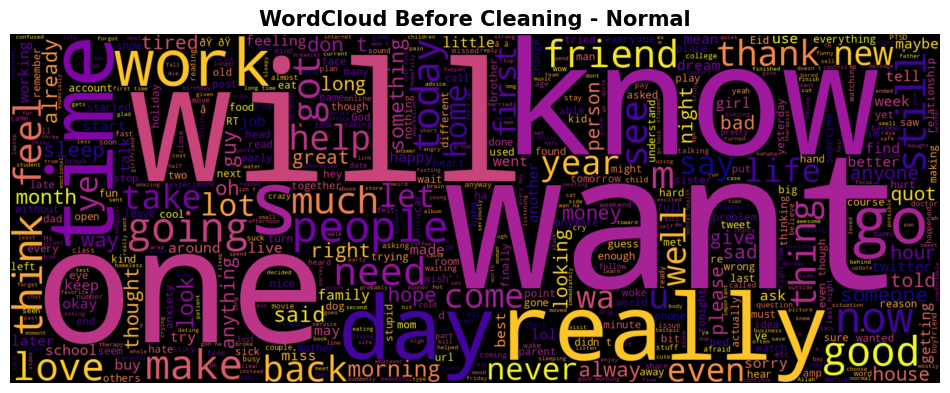

In [55]:
# wordcloud dari status Normal
plt.figure(figsize=(12,12))
wc = WordCloud(max_words=1000,
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=False,
               stopwords=STOPWORDS).generate(' '.join(clean_normal.statement))

plt.title("WordCloud Before Cleaning - Normal", size=15, weight='bold')
plt.imshow(wc, interpolation= "bilinear")
plt.axis('off')

(-0.5, 1599.5, 599.5, -0.5)

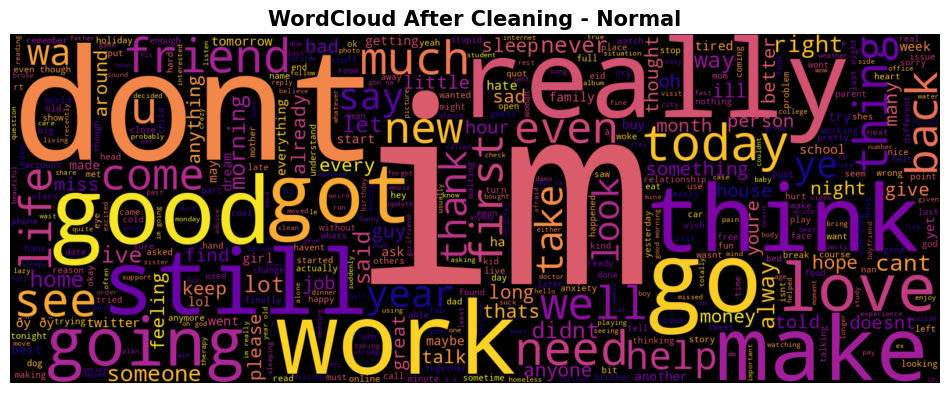

In [56]:
# Mengonversi semua nilai ke string
clean_normal['cleaned_final'] = clean_normal['cleaned_final'].astype(str)

# wordcloud dari status Normal
plt.figure(figsize=(12,12))
wc = WordCloud(max_words=1000,
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=False,
               stopwords=STOPWORDS).generate(' '.join(clean_normal.cleaned_final))

plt.title("WordCloud After Cleaning - Normal", size=15, weight='bold')
plt.imshow(wc, interpolation= "bilinear")
plt.axis('off')

Dapat dilihat terdapat perbedaan antara sebelum dan sesudah

## 6.2 Semua data

(-0.5, 1599.5, 599.5, -0.5)

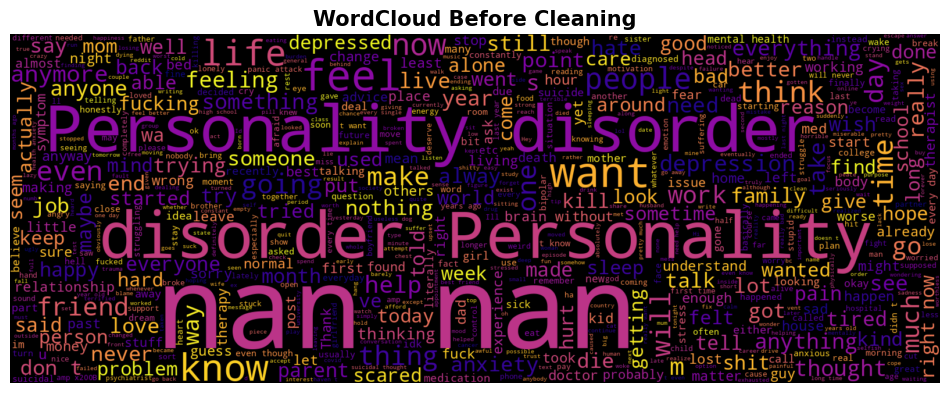

In [57]:
# wordcloud dari status Normal
plt.figure(figsize=(12,12))
wc = WordCloud(max_words=1000,
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=False,
               stopwords=STOPWORDS).generate(' '.join(df_clean.statement.astype(str)))

plt.title("WordCloud Before Cleaning", size=15, weight='bold')
plt.imshow(wc, interpolation= "bilinear")
plt.axis('off')

(-0.5, 1599.5, 599.5, -0.5)

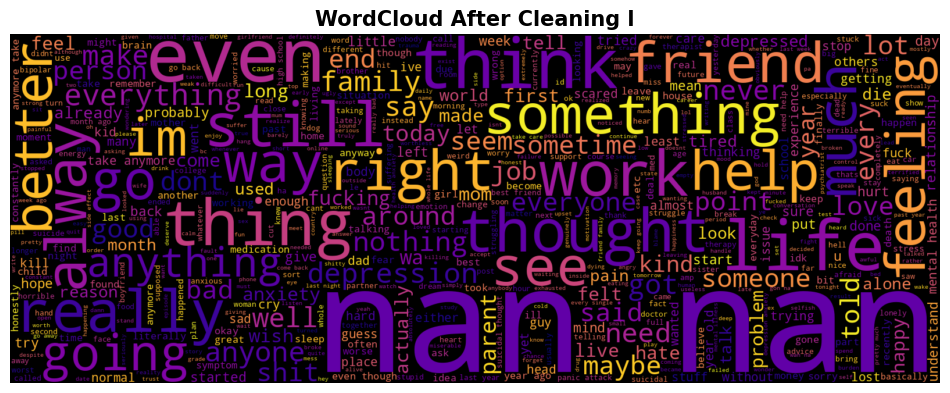

In [58]:
# Mengonversi semua nilai ke string
df_clean['cleaned_final'] = df_clean['cleaned_final'].astype(str)

# wordcloud dari status Normal
plt.figure(figsize=(12,12))
wc = WordCloud(max_words=1000,
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=False,
               stopwords=STOPWORDS).generate(' '.join(df_clean.cleaned_final))

plt.title("WordCloud After Cleaning l", size=15, weight='bold')
plt.imshow(wc, interpolation= "bilinear")
plt.axis('off')

Dapat dilihat secara overall sudah terdapat perbedaan dengan menggunakann stopwords

# 7. Model Building - LSTM

Pada Bagian ini akan menggunakan LSTM sebagai model yang dipilih

## 7.1 Text Vectorization

In [262]:
# Get Vocabularies
#conver stopword menjadi list
stop_words_list = list(stop_words)
# min_df: kata harus muncul di setidaknya 10 dokumen
# max_df: kata yang muncul di lebih dari 85% dokumen dihapus
Vectorize = CountVectorizer(ngram_range=(1, 2), min_df=10, max_df=0.85, stop_words=stop_words_list)
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)
X_val_vec = Vectorize.transform(X_val)

X_train_vec

<39070x27288 sparse matrix of type '<class 'numpy.int64'>'
	with 1899328 stored elements in Compressed Sparse Row format>

In [263]:
# Finding the Number of Vocabs and Max Token Length in One Document

total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  27288
Maximum Sentence Length :  2520 tokens


In [264]:
text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                        input_shape=(1,))

text_vectorization.adapt(X_train)

In [265]:
# Example Result

## Document example
print('Document example')
print(X_train[2])
print('')

## Result of Text Vectorization
print('Result of Text Vectorization')
print(text_vectorization([X_train[2]]))
print('Vector size : ', text_vectorization([X_train[2]]).shape)

Document example
wrong back dear forward doubt stay restless restless place

Result of Text Vectorization
tf.Tensor([[ 163   26 1995 ...    0    0    0]], shape=(1, 2520), dtype=int64)
Vector size :  (1, 2520)


## 7.2 Word Embedding

In [266]:
# Embedding
embedding = Embedding(input_dim=total_vocab,
                      output_dim=32,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len)

## 7.3 Model Training

In [ ]:
# Model Training using LSTM
%%time
## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_1 = Sequential()
model_lstm_1.add(text_vectorization)
model_lstm_1.add(embedding)
model_lstm_1.add(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed)))
model_lstm_1.add(BatchNormalization())
model_lstm_1.add(Dropout(rate = 0.1, seed=seed))
model_lstm_1.add(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed)))
model_lstm_1.add(BatchNormalization())
model_lstm_1.add(Dropout(rate = 0.1, seed=seed))
model_lstm_1.add(Dense(7, activation='softmax'))

#compile model
model_lstm_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

CPU times: user 898 ms, sys: 8.5 ms, total: 907 ms
Wall time: 1.02 s


In [ ]:
model_lstm_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 2520)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 2520, 32)          873216    
                                                                 
 lstm (LSTM)                 (None, 2520, 32)          8320      
                                                                 
 batch_normalization (Batch  (None, 2520, 32)          128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 2520, 32)          0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                3

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/p2-ftds033-rmt-g7-junjung214/lstm_model_1.keras', save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
# Melatih model
%%time
model_lstm_1_hist = model_lstm_1.fit(
    X_train,
    y_train_ohe,
    epochs=100,
    validation_data=(X_val, y_val_ohe),
    callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
1221/1221 [==============================] - 268s 213ms/step - loss: 1.6299 - accuracy: 0.3020 - val_loss: 4.8400 - val_accuracy: 0.0707
Epoch 2/100
1221/1221 [==============================] - 178s 146ms/step - loss: 1.6001 - accuracy: 0.3114 - val_loss: 8.4379 - val_accuracy: 0.0707
Epoch 3/100
1221/1221 [==============================] - 167s 137ms/step - loss: 1.5993 - accuracy: 0.3091 - val_loss: 7.6736 - val_accuracy: 0.2084
Epoch 4/100
1221/1221 [==============================] - 172s 141ms/step - loss: 1.5987 - accuracy: 0.3083 - val_loss: 2.0089 - val_accuracy: 0.3139
Epoch 5/100
1221/1221 [==============================] - 169s 138ms/step - loss: 1.5987 - accuracy: 0.3094 - val_loss: 6.9589 - val_accuracy: 0.2084
Epoch 6/100
1221/1221 [==============================] - 167s 137ms/step - loss: 1.5985 - accuracy: 0.3130 - val_loss: 1.7416 - val_accuracy: 0.2084
Epoch 7/100
1221/1221 [==============================] - 217s 178ms/step - loss: 1.5981 - accuracy: 0.3135

## 7.4 Model Evaluation

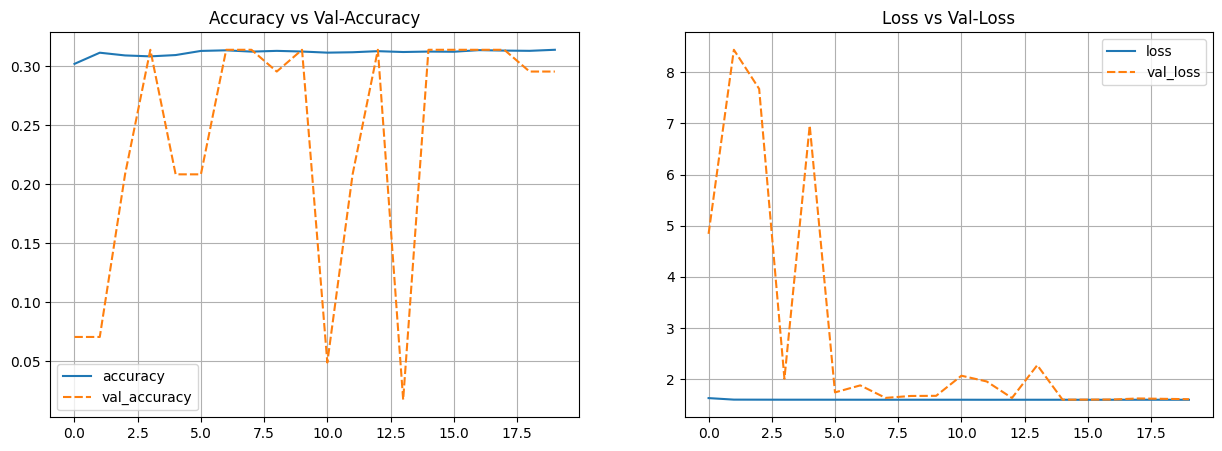

In [ ]:
# Plot Training Results

model_lstm_1_hist_df = pd.DataFrame(model_lstm_1_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_1_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_1_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

Dapat dilihat bahwasanya model mengalami underfit dan ada beberapa epoch yang mengalam exploding.

Model juga diberhentiikan terlebih dahulu karena selama 5 epoch tidak adanya perubahan yang lebih baik pada parameter val_los

In [ ]:
# Predict class probabilities for the training data
y_train_pred_proba = model_lstm_1.predict(X_train)

# Convert predicted probabilities to class labels
y_train_pred = np.argmax(y_train_pred_proba, axis=1)

# Convert one-hot encoded y_train to class labels
y_train_true = np.argmax(y_train_ohe, axis=1)

# Generate classification report with updated target names
target_names = ['Normal', 'Depression', 'Suicidal', 'Anxiety', 'Bipolar', 'Stress', 'Personality disorder']
report = classification_report(y_train_true, y_train_pred, target_names=target_names)

# Print the classification report
print(report)

1221/1221 [==============================] - 72s 58ms/step
                      precision    recall  f1-score   support

              Normal       0.31      1.00      0.48     12270
          Depression       0.00      0.00      0.00     11541
            Suicidal       1.00      0.00      0.00      8140
             Anxiety       0.00      0.00      0.00      2767
             Bipolar       0.00      0.00      0.00      1913
              Stress       0.00      0.00      0.00      1754
Personality disorder       0.00      0.00      0.00       685

            accuracy                           0.31     39070
           macro avg       0.19      0.14      0.07     39070
        weighted avg       0.31      0.31      0.15     39070



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
# Predict class probabilities for the test data
y_test_pred_proba = model_lstm_1.predict(X_test)

# Convert predicted probabilities to class labels
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

# Convert one-hot encoded y_test to class labels
y_test_true = np.argmax(y_test_ohe, axis=1)

# Generate classification report with updated target names
target_names = ['Normal', 'Depression', 'Suicidal', 'Anxiety', 'Bipolar', 'Stress', 'Personality disorder']
report = classification_report(y_test_true, y_test_pred, target_names=target_names)

# Print the classification report
print(report)

240/240 [==============================] - 14s 59ms/step
                      precision    recall  f1-score   support

              Normal       0.31      1.00      0.48      2406
          Depression       0.00      0.00      0.00      2263
            Suicidal       0.00      0.00      0.00      1596
             Anxiety       0.00      0.00      0.00       543
             Bipolar       0.00      0.00      0.00       375
              Stress       0.00      0.00      0.00       344
Personality disorder       0.00      0.00      0.00       134

            accuracy                           0.31      7661
           macro avg       0.04      0.14      0.07      7661
        weighted avg       0.10      0.31      0.15      7661



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## 7.5 Conclusion

Daapat kita lihat dari hasil Model LSTM  bahwasanya :
1. Model dibangun denggan Text Vectorization beradasrkan Countvercotr yang memiliki filterasi vocab dengan implementasi n_gram sera nilai minimal 10 document serta maximal 85%.
2. Model dibangun dengan menggunakan Embedding dengan nilai output_dim sebesar 32,
3. Dalam pengukuran akan menggunakan f1-score karena dataset cenderung imbalance dan hal ini akan sangat berpengaruh terhadap peforma model.
4. Hasil dari model ini cenderung sangat underfit dimana juga dapat dilihhat bahwasanya model ini hanya dapat memprediksi dengan class normal pada pengujian test dengan f1-score yang cenderung rendah.
5. Untuk handling model underfit dapat dilakukan dengan menambah hiden layer sertta menambah banyaknya neuron dalam setiap hiden layer tetapi dengan resiko komputasi yang akan semakin lama.

In [ ]:
# Freze model

model_lstm_1.trainable = False
model_lstm_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 2520)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 2520, 32)          873216    
                                                                 
 lstm (LSTM)                 (None, 2520, 32)          8320      
                                                                 
 batch_normalization (Batch  (None, 2520, 32)          128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 2520, 32)          0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                3

In [ ]:
#save model
model_lstm_1.save('/content/drive/MyDrive/p2-ftds033-rmt-g7-junjung214/model_lstm_1.keras')

# 8. Model Building - LSTM with Bidirectional

## 8.1 Model Training

In [64]:
# Model Training using LSTM
%%time
## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
lstm_bidirectional = Sequential()
lstm_bidirectional.add(text_vectorization)
lstm_bidirectional.add(embedding)
lstm_bidirectional.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
lstm_bidirectional.add(BatchNormalization())
lstm_bidirectional.add(Dropout(rate = 0.1, seed=seed))
lstm_bidirectional.add(Bidirectional((LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed)))))
lstm_bidirectional.add(BatchNormalization())
lstm_bidirectional.add(Dropout(rate = 0.1, seed=seed))
lstm_bidirectional.add(Dense(7, activation='softmax'))

#compile model
lstm_bidirectional.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

CPU times: user 1.17 s, sys: 7.26 ms, total: 1.18 s
Wall time: 1.21 s


In [65]:
#summary model
lstm_bidirectional.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 2520)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 2520, 32)          873216    
                                                                 
 bidirectional (Bidirection  (None, 2520, 64)          16640     
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 2520, 64)          256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 2520, 64)          0         
                                                        

In [66]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/p2-ftds033-rmt-g7-junjung214/lstm_bidirectional.keras', save_best_only=True, monitor='val_loss', mode='min')

In [67]:
# Melatih model
%%time
lstm_bidirectional_hist = lstm_bidirectional.fit(
    X_train,
    y_train_ohe,
    epochs=50,
    validation_data=(X_val, y_val_ohe),
    callbacks=[early_stopping, model_checkpoint])

Epoch 1/50
1221/1221 [==============================] - 396s 316ms/step - loss: 0.8844 - accuracy: 0.6698 - val_loss: 0.7186 - val_accuracy: 0.7197
Epoch 2/50
1221/1221 [==============================] - 312s 256ms/step - loss: 0.5391 - accuracy: 0.7989 - val_loss: 0.6697 - val_accuracy: 0.7612
Epoch 3/50
1221/1221 [==============================] - 312s 256ms/step - loss: 0.3994 - accuracy: 0.8518 - val_loss: 0.8727 - val_accuracy: 0.7241
Epoch 4/50
1221/1221 [==============================] - 313s 256ms/step - loss: 0.2988 - accuracy: 0.8924 - val_loss: 0.7961 - val_accuracy: 0.7266
Epoch 5/50
1221/1221 [==============================] - 309s 253ms/step - loss: 0.2290 - accuracy: 0.9184 - val_loss: 0.9377 - val_accuracy: 0.7377
Epoch 6/50
1221/1221 [==============================] - 306s 251ms/step - loss: 0.1814 - accuracy: 0.9358 - val_loss: 1.0516 - val_accuracy: 0.7361
Epoch 7/50
1221/1221 [==============================] - 300s 246ms/step - loss: 0.1538 - accuracy: 0.9476 - val_

## 8.2 Model Evalutaion



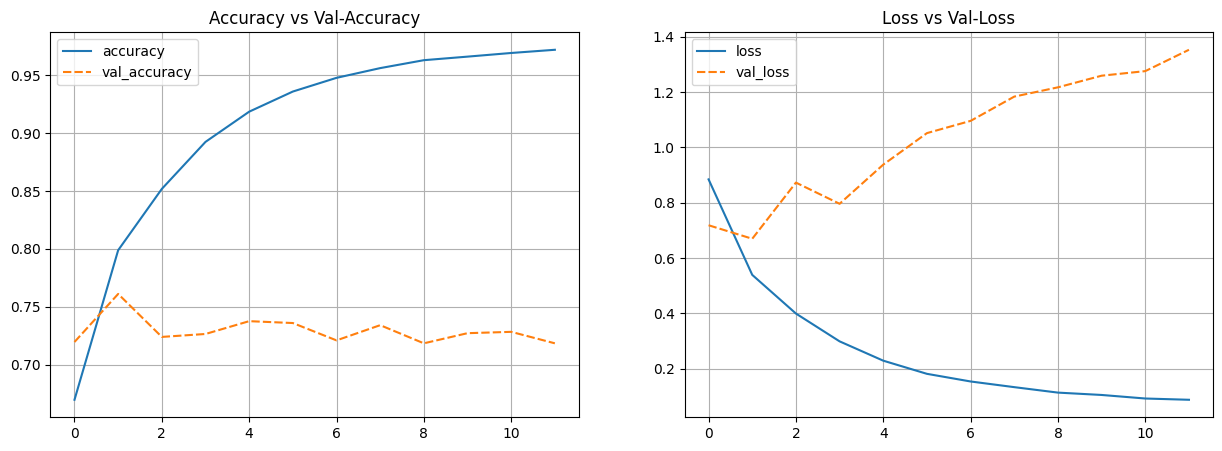

In [68]:
# Plot Training Results

lstm_bidirectional_hist_df = pd.DataFrame(lstm_bidirectional_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=lstm_bidirectional_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=lstm_bidirectional_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

Dapat dilihat dari hasil diatas bahwasanya model cenderung overfit dan perlu diberikan pendekatan regulization, karena perbaedaan yang cukup banyak antara hasiln train dan test bahkan kecenderungan tren validation yang semakin buruk dalam segi loss ataupun acuracy

In [71]:
lstm_bidirectional = load_model('/content/drive/MyDrive/p2-ftds033-rmt-g7-junjung214/lstm_bidirectional.keras')

In [72]:
# Predict class probabilities for the training data
y_train_pred_proba = lstm_bidirectional.predict(X_train)

# Convert predicted probabilities to class labels
y_train_pred = np.argmax(y_train_pred_proba, axis=1)

# Convert one-hot encoded y_train to class labels
y_train_true = np.argmax(y_train_ohe, axis=1)

# Generate classification report with updated target names
target_names = ['Normal', 'Depression', 'Suicidal', 'Anxiety', 'Bipolar', 'Stress', 'Personality disorder']
report = classification_report(y_train_true, y_train_pred, target_names=target_names)

# Print the classification report
print(report)

1221/1221 [==============================] - 135s 110ms/step
                      precision    recall  f1-score   support

              Normal       0.94      0.99      0.96     12270
          Depression       0.84      0.84      0.84     11541
            Suicidal       0.81      0.83      0.82      8140
             Anxiety       0.86      0.94      0.90      2767
             Bipolar       0.97      0.86      0.91      1913
              Stress       0.96      0.54      0.69      1754
Personality disorder       0.89      0.69      0.77       685

            accuracy                           0.88     39070
           macro avg       0.89      0.81      0.84     39070
        weighted avg       0.88      0.88      0.87     39070



In [78]:

# Hitung F1 score
f1 = f1_score(y_train_true, y_train_pred, average='weighted')

print(f"F1 Score Train (Weighted): {f1:.4f}")

F1 Score Train (Weighted): 0.8745


In [73]:
# Predict class probabilities for the test data
y_test_pred_proba = lstm_bidirectional.predict(X_test)

# Convert predicted probabilities to class labels
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

# Convert one-hot encoded y_test to class labels
y_test_true = np.argmax(y_test_ohe, axis=1)

# Generate classification report with updated target names
target_names = ['Normal', 'Depression', 'Suicidal', 'Anxiety', 'Bipolar', 'Stress', 'Personality disorder']
report = classification_report(y_test_true, y_test_pred, target_names=target_names)

# Print the classification report
print(report)

240/240 [==============================] - 27s 110ms/step
                      precision    recall  f1-score   support

              Normal       0.86      0.95      0.90      2406
          Depression       0.69      0.73      0.71      2263
            Suicidal       0.68      0.65      0.66      1596
             Anxiety       0.73      0.82      0.77       543
             Bipolar       0.88      0.66      0.76       375
              Stress       0.78      0.27      0.40       344
Personality disorder       0.68      0.40      0.50       134

            accuracy                           0.76      7661
           macro avg       0.76      0.64      0.67      7661
        weighted avg       0.76      0.76      0.75      7661



In [77]:

# Hitung F1 score
f1 = f1_score(y_test_true, y_test_pred, average='weighted')

print(f"F1 Score Test (Weighted): {f1:.4f}")

F1 Score Test (Weighted): 0.7490


## 8.3 Conclusion

Dalam hasil model diatas dapat disimpulkan seperti ini :
1. Model dapat melakukan prediksi kesegala kelas tetapi ada yang beberapa kelas yang kecenderungan salah juga besar seperti pada Stress dan Personality disorder dimna hasil dari prediksi dalam tes mengalami kecenderungan salah lebih besar
2. Hasil parameter dalam model ini adalah f1-score dimana mengalami peningkatan cukup signifikan nilai train 0.87 dan tes 0.75 dari model LSTM yang tidak mengimplementasikan bilinear. meskipun dalam pneerapan bilinear memakan waktu lebih lama tetapi hasil yang didapatkan sangat meningkat meskipun masih overfit

# 9. Save Model

In [74]:
# Freze model

lstm_bidirectional.trainable = False
lstm_bidirectional.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 2520)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 2520, 32)          873216    
                                                                 
 bidirectional (Bidirection  (None, 2520, 64)          16640     
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 2520, 64)          256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 2520, 64)          0         
                                                        

In [278]:
#save model
lstm_bidirectional.save('/content/drive/MyDrive/p2-ftds033-rmt-g7-junjung214/lstm_bidirectional.keras')

# 10. Inference Model

In [279]:
# Load the saved model
lstm_bidirectional = load_model('/content/drive/MyDrive/p2-ftds033-rmt-g7-junjung214/lstm_bidirectional.keras')

# New data to predict
new_data = ["I Feel happy because i get gift from my husband."]

# Make predictions
predictions = lstm_bidirectional.predict(new_data)

# Get the predicted class
predicted_classes = np.argmax(predictions, axis=1)

# Map predicted classes to labels
target_names = ['Normal', 'Depression', 'Suicidal', 'Anxiety', 'Bipolar', 'Stress', 'Personality disorder']
predicted_labels = [target_names[i] for i in predicted_classes]

# Print the predicted labels
print(new_data)
print(predicted_labels)


1/1 [==============================] - 3s 3s/step
['I Feel happy because i get gift from my husband.']
['Normal']


## 11. Kesimpuulan

Dalam Hasil diatas dapat dilihat bahwasanya ada beberapa kesimpulan yang dapat ditraik berdasarkan sub bab bagian :
1. Kesimpulan EDA :
  - Data bersifat imbalance dan persebrannya sangat tidak merata sehingga akan sangat bisa berpengaruh pada model
  - Terdapat beberapa Vocab yang muncul di semua kelas sehingga perlu ditambahkan ke daftar wordstop untuk meningkatkan peforma model
2. Kesimpulan Model :
  - Dalam Hasil diatas dapat dilihat berdasrakan penerapan Model LSTM dengan Hidden layer yang bersifat Bidirectional mendapati hasil f1-score yang lumayan bagus tetapi masih ada kecenderungan **overfit** yakni sebesar 0.10 pada train dan test dengan parameter f1-score
  - Dalam overall model dapat memprediksi setiap class tetapi ada 2 class yang kurang bagus yakni depression and personality disorder
3. Kesimpulan Bisnis :
  - Dalam kasus ini dapat membantu perusahaan dalam mengidentifikasi seseorang terkait kesehatan mental berdasrakan apa yang di rasakan yang tertuang didalam tulisan sehingga perusahaan akan lebih bisa menghandling orang tersebut sesuai dengan kelasnya
4. Next Improvement :
  - Dalam kasus ini sangat banyak yang bisa di tingkatkan seperti halnya :
      1. Penggunaan Balancing Data
      2. Penggunaan TF-IDF untuk memaksimalkan vectoriztion dan menguji coba peforma model
      3. Penggunaan Transfer Learning terhadap model
      4. Pemilihan class yang memilki data majority sehingga dalam kasus ini tidak terlalu banyak kelas tetapi hanya beberapa kelas saja dengan kualitas data yang juga bagus
      5. Handling Preprocessing yang lebih detailing seperti word stop yang seharusnya bisa lebih bervariatif
      6. Penggunaan Regulization yang lebih kompleks supaya tidak adanya overfiting model
  -